In [1]:
import pandas as pd
import os
import numpy as np
from os import listdir
from os.path import isfile, join
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

drive.mount('/content/drive/', force_remount=True)
pd.options.mode.chained_assignment = None

Mounted at /content/drive/


# testing on one file

Need to do cleaning with flag stuff. Sometimes the data isn't always good (M flag for missing). In order to deal with this, I am taking an average of previous values to make up the corrupt/non-existent data point.

I have a function, howMany and bestOne, that check how many previous values should be used to calculate the new data point. I test with a window size 1-5 to see which one yields the best result of the next 3 hours. 

In [55]:
#January 1st, 24 hours 
# USW00023234 = SF
# USW00023232 = SAC
# USW00023188 = SD
# USW00023174 = LA
df = pd.read_csv("/content/drive/MyDrive/Fairness ML/FairnessML_git/DataProcess/USW00023174.csv")

#drop columns we don't need
df.drop('STATION', axis=1, inplace=True)
df.drop('NAME', axis=1, inplace=True)
df.drop('LATITUDE', axis=1, inplace=True)
df.drop('LONGITUDE', axis=1, inplace=True)
df.drop('ELEVATION', axis=1, inplace=True)
df.drop('month', axis=1, inplace=True)
df.drop('hour', axis=1, inplace=True)
df.drop('day', axis=1, inplace=True)

df

,DATE,HLY-TEMP-NORMAL,meas_flag_HLY-TEMP-NORMAL,comp_flag_HLY-TEMP-NORMAL,years_HLY-TEMP-NORMAL,HLY-TEMP-10PCTL,meas_flag_HLY-TEMP-10PCTL,comp_flag_HLY-TEMP-10PCTL,years_HLY-TEMP-10PCTL,HLY-TEMP-90PCTL,...,comp_flag_HLY-WIND-1STPCT,years_HLY-WIND-1STPCT,HLY-WIND-2NDDIR,meas_flag_HLY-WIND-2NDDIR,comp_flag_HLY-WIND-2NDDIR,years_HLY-WIND-2NDDIR,HLY-WIND-2NDPCT,meas_flag_HLY-WIND-2NDPCT,comp_flag_HLY-WIND-2NDPCT,years_HLY-WIND-2NDPCT
0,01-01T00:00:00,54.6,,S,30,50.0,,S,30,60.1,...,S,30,2.0,,S,30,17.8,,S,30
1,01-01T01:00:00,53.7,,S,30,48.9,,S,30,59.0,...,S,30,2.0,,S,30,18.6,,S,30
2,01-01T02:00:00,52.5,,S,30,46.9,,S,30,57.9,...,S,30,2.0,,S,30,22.3,,S,30
3,01-01T03:00:00,51.7,,S,30,46.9,,S,30,57.0,...,S,30,2.0,,S,30,22.8,,S,30
4,01-01T04:00:00,51.0,,S,30,46.0,,S,30,55.9,...,S,30,2.0,,S,30,19.4,,S,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12-31T19:00:00,57.3,,S,30,53.1,,S,30,63.0,...,S,30,6.0,,S,30,16.3,,S,30
8756,12-31T20:00:00,57.1,,S,30,52.0,,S,30,62.1,...,S,30,1.0,,S,30,16.1,,S,30
8757,12-31T21:00:00,56.5,,S,30,51.1,,S,30,62.1,...,S,30,3.0,,S,30,13.9,,S,30
8758,12-31T22:00:00,55.8,,S,30,51.1,,S,30,61.0,...,S,30,1.0,,S,30,12.9,,S,30


# When data is missing

NOAA has flags for missing data. X is fine, just means they rounded a non-zero to a zero value. M is bad, it means data is missing. When data is missing, fill it with a value from the average of past values. These function determine how many past values should be used to fill in the missing data. Value can range from 1 past data to 5 past datas.

In [56]:
# trying to figure out how many values of prev I should take in the average
def howMany(num, col, df):
    error = 0
    for i in range(num, 3+num):
        avg = sum(list(df[col][i-num:i]))/num
        error+= abs(df[col][i+1] - avg)
    
    return error/(300)

def bestOne(col, df):
    allResults = {}
    for i in range(1,6):
        error = howMany(i, col, df)
        allResults[error] = i
    lowest = min(allResults.keys())
    return allResults[lowest]

# bestVal = bestOne('HLY-CLOD-PCTCLR', df)
bestVal = bestOne('HLY-TEMP-NORMAL', df)
print(bestVal)

5


In [57]:
measurementFlags = []
completenessFlags = []
for column in df.columns:
    if 'meas' in column:
        measurementFlags.append(column)
    elif 'comp' in column:
        completenessFlags.append(column)

In [58]:
#checks the flags and removes any rows corresponding with 'M' which means the data is missing
#if measurement flag is == " " that means the data is fine

# same number of flags
# print(len(measurementFlags))
# print(len(completenessFlags))

#for every row, check every flag and see if their value has an invalid measurement or completeness

print(len(measurementFlags))
# X is ok = rounded down
# M is bad = missing
badVals = {}
for flag in measurementFlags:
    print(flag)
    for i in range(len(df[flag])):
        if 'M' in df[flag][i]:
            badVals[i] = flag
            print("i is: ", i)
            print(df[flag][i])
            avg = 0
            col = flag[10:]
            print(df[col][i-3:i+1])
            optimal_pastVals = bestOne(col, df)
            
            if i - optimal_pastVals > 0: #use the num of optimal past vals to calculate a replacement val for missing
                avg = sum(list(df[col][i-optimal_pastVals:i]))/optimal_pastVals
            elif i - 1 <= 0: #no past data to rely on 
                avg = 0
            elif i - 1 > 0:
                avg = sum(list(df[col][i-1:i]))/i
            else:
                print("something is wrong here.")
                break
            
            df.at[i, col] = avg
            print("new value: ", df[col][i])

Streaming output truncated to the last 5000 lines.
4733      12.450
4734      13.275
4735   -9999.000
Name: HLY-CLOD-PCTBKN, dtype: float64
new value:  12.862499999999999
i is:  4757
M
4754      13.9
4755      11.6
4756      14.3
4757   -9999.0
Name: HLY-CLOD-PCTBKN, dtype: float64
new value:  12.95
i is:  4758
M
4755      11.60
4756      14.30
4757      12.95
4758   -9999.00
Name: HLY-CLOD-PCTBKN, dtype: float64
new value:  13.625
i is:  4759
M
4756      14.300
4757      12.950
4758      13.625
4759   -9999.000
Name: HLY-CLOD-PCTBKN, dtype: float64
new value:  13.2875
i is:  4779
M
4776      16.7
4777      13.2
4778      13.5
4779   -9999.0
Name: HLY-CLOD-PCTBKN, dtype: float64
new value:  13.35
i is:  4781
M
4778      13.50
4779      13.35
4780      14.00
4781   -9999.00
Name: HLY-CLOD-PCTBKN, dtype: float64
new value:  13.675
i is:  4782
M
4779      13.350
4780      14.000
4781      13.675
4782   -9999.000
Name: HLY-CLOD-PCTBKN, dtype: float64
new value:  13.8375
i is:  4783
M
4780 

In [59]:
# len(badVals)
# # check only in June, July, August
june = 0
july = 0
august = 0
just_June = []
just_July = []
just_August = []
for i in badVals.keys():
  if i >=3624 and i < 4344:
    # print("june, i is: ", i)
    just_June.append(i)
    june+=1
  elif i >= 4344 and i <5088:
    just_July.append(i)
    # print("july, i is: ", i)
    july+=1
  elif i >= 5088 and i <5832:
    just_August.append(i)
    # print("august, i is: ", i)
    august+=1

print("june errors: ", str(june), "july errors: ", str(july), " august errors: ", str(august))

# badVals

june errors:  144 july errors:  132  august errors:  95


In [60]:
# one = just_June[0]
# df.iloc[one:one+1, 0]
for i in just_August:
  print(df.iloc[i:i+1, 0])

5091    08-01T03:00:00
Name: DATE, dtype: object
5093    08-01T05:00:00
Name: DATE, dtype: object
5094    08-01T06:00:00
Name: DATE, dtype: object
5095    08-01T07:00:00
Name: DATE, dtype: object
5096    08-01T08:00:00
Name: DATE, dtype: object
5115    08-02T03:00:00
Name: DATE, dtype: object
5117    08-02T05:00:00
Name: DATE, dtype: object
5118    08-02T06:00:00
Name: DATE, dtype: object
5119    08-02T07:00:00
Name: DATE, dtype: object
5120    08-02T08:00:00
Name: DATE, dtype: object
5139    08-03T03:00:00
Name: DATE, dtype: object
5141    08-03T05:00:00
Name: DATE, dtype: object
5142    08-03T06:00:00
Name: DATE, dtype: object
5143    08-03T07:00:00
Name: DATE, dtype: object
5144    08-03T08:00:00
Name: DATE, dtype: object
5163    08-04T03:00:00
Name: DATE, dtype: object
5165    08-04T05:00:00
Name: DATE, dtype: object
5166    08-04T06:00:00
Name: DATE, dtype: object
5167    08-04T07:00:00
Name: DATE, dtype: object
5168    08-04T08:00:00
Name: DATE, dtype: object
5187    08-05T03:00:

In [ ]:
df.columns.get_loc("HLY-CLOD-PCTOVC")

61

In [ ]:
just_August

[5088,
 5089,
 5090,
 5091,
 5093,
 5094,
 5095,
 5096,
 5112,
 5113,
 5114,
 5115,
 5117,
 5118,
 5119,
 5120,
 5136,
 5137,
 5138,
 5139,
 5141,
 5142,
 5143,
 5144,
 5160,
 5161,
 5162,
 5163,
 5165,
 5166,
 5167,
 5168,
 5184,
 5185,
 5186,
 5187,
 5189,
 5190,
 5191,
 5192,
 5208,
 5209,
 5210,
 5211,
 5213,
 5214,
 5215,
 5216,
 5232,
 5233,
 5234,
 5235,
 5237,
 5238,
 5239,
 5240,
 5255,
 5256,
 5257,
 5258,
 5259,
 5261,
 5262,
 5263,
 5264,
 5280,
 5281,
 5282,
 5283,
 5285,
 5286,
 5287,
 5288,
 5304,
 5305,
 5306,
 5307,
 5309,
 5310,
 5311,
 5312,
 5328,
 5329,
 5330,
 5331,
 5333,
 5334,
 5335,
 5336,
 5352,
 5353,
 5354,
 5355,
 5357,
 5358,
 5359,
 5360,
 5376,
 5377,
 5378,
 5379,
 5381,
 5382,
 5383,
 5384,
 5400,
 5401,
 5402,
 5403,
 5405,
 5406,
 5407,
 5408,
 5424,
 5425,
 5426,
 5427,
 5429,
 5430,
 5431,
 5432,
 5448,
 5449,
 5450,
 5451,
 5453,
 5454,
 5455,
 5456,
 5472,
 5473,
 5474,
 5475,
 5477,
 5478,
 5479,
 5480,
 5496,
 5497,
 5498,
 5499,
 5501,
 5502,

In [ ]:
monthBegin = 5088 #change this
monthEnd = 5832 # change this
y = []
for i in range(monthBegin, monthEnd):
  y.append(df.iloc[i:i+1, 61])

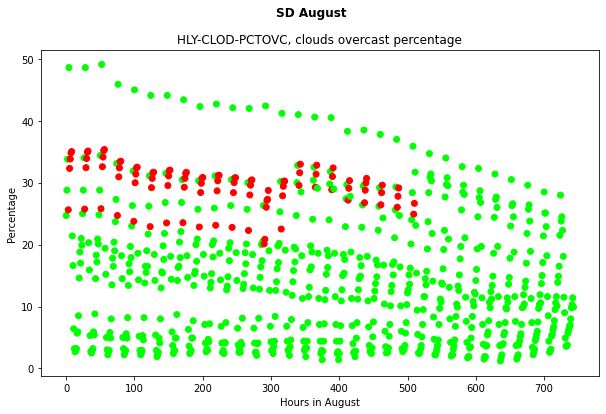

In [ ]:

x = []
hoursInMonth = 24*31
for i in range(0,hoursInMonth):
  x.append(i)

col = []
for i in range(monthBegin, monthEnd):
  col.append('lime')

for j in just_August: #change this
  badVal = abs(monthBegin-j)
  col[badVal] = 'red'

fig, ax = plt.subplots(figsize=(10,6))
plt.xlabel('Hours in August')
plt.ylabel('Percentage')
plt.scatter(x,df.iloc[monthBegin:monthEnd, 61], c=col)

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.suptitle('SD August', weight = 'bold')
plt.title('HLY-CLOD-PCTOVC, clouds overcast percentage')
# plt.legend()
# plt.show()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season/errorChecks/' 
plt.savefig(pathToSaveData+ 'LA_augustError.jpg')